In [1]:
import os 
 
os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Initialisation de constantes
batch_size = 16 # taille de l'échantillon dont les erreurs de prédiction servent à maj les paramètres
latent_dim = 32 # trop faible = compression extrême rendant illisible l'image
                # trop élevé = reconstruction fidèle mais s'écarte de l'objectif de compression lié à l'usage d'un VAE
kl_weight = 0.5 # trop faible = reconstruction impeccable des données mais aucun pouvoir d'échantillonnage
                # trop élevé = reconstruction bruitée
num_classes = 10 # vérifier le nombre de classes dans les données (par défaut 10)
dim_params = 784 # vérifier les dimensions de vos images (H*W)
seed = 0xffff

In [4]:
# Chargement des packages
import jax
import flax
import optax
# import orbax

import flax.linen as nn
import jax.numpy as jnp
from jax.typing import ArrayLike

from typing import Tuple, Callable
from math import sqrt

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

key = jax.random.PRNGKey(seed)

In [5]:
# from src.data_modeling.VAE import FeedForward
from src.data_modeling.VAE import VAE
from src.data_modeling.train import generate_train_step
from src.data_processing import prepare_test_set
from src.data_processing import get__y_true

In [6]:
import torchvision.transforms as T # message d'erreur : à ignorer
from torchvision.datasets import MNIST
# from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
#from torchvision.transforms import Grayscale
#import torch

C:\ProgramData\anaconda3\envs\keras_jax\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] La procédure spécifiée est introuvable'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [7]:
train_dataset = MNIST('../data', train = True, transform=T.ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) 

In [8]:
key, model_key = jax.random.split(key)

model = VAE(latent_dim=latent_dim)
optimizer = optax.adamw(learning_rate=1e-4)

train_step, train, params, opt_state = generate_train_step(model_key, model, optimizer, batch_size=batch_size, num_classes=num_classes, dim_params=dim_params)

In [9]:
params, opt_state = train(key, params, freq=500, epochs=10, opt_state=opt_state, train_loader=train_loader, batch_size=batch_size, train_step=train_step)

Epoch 0 | étape 500 | loss = 36.55783462524414 ~ mse = 36.24393081665039. kl = 0.31390076875686646
Epoch 0 | étape 1000 | loss = 28.37625503540039 ~ mse = 28.00140380859375. kl = 0.3748699128627777
Epoch 0 | étape 1500 | loss = 25.30596923828125 ~ mse = 24.7032527923584. kl = 0.6027082800865173
Epoch 0 | étape 2000 | loss = 23.696937561035156 ~ mse = 23.053110122680664. kl = 0.6438288688659668
Epoch 0 | étape 2500 | loss = 22.61939811706543 ~ mse = 22.02173614501953. kl = 0.5976674556732178
Epoch 0 | étape 3000 | loss = 22.150775909423828 ~ mse = 21.581985473632812. kl = 0.5687988996505737
Epoch 0 | étape 3500 | loss = 21.764497756958008 ~ mse = 21.179914474487305. kl = 0.5845811367034912
Epoch 1 | étape 500 | loss = 21.236845016479492 ~ mse = 20.459196090698242. kl = 0.777642011642456
Epoch 1 | étape 1000 | loss = 20.923961639404297 ~ mse = 20.046642303466797. kl = 0.877307653427124
Epoch 1 | étape 1500 | loss = 20.78485679626465 ~ mse = 19.859207153320312. kl = 0.9256515502929688
Epo

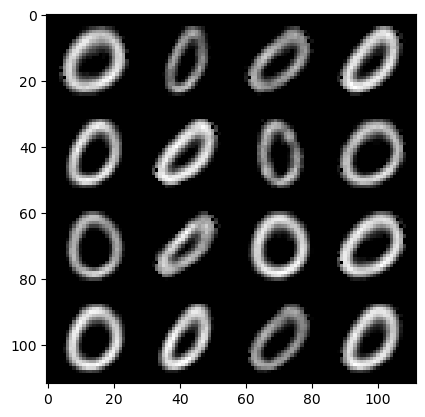

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
model.img_gen(key, params, n_classes=num_classes, img_class=0, h=4, w=4)

In [11]:
test_dataset = MNIST('data', train = False, transform=T.ToTensor(), download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [12]:
total_loss, total_mse, total_kl, loss_distrib = model.evaluate(key, params, n_classes=num_classes, data_loader=test_loader, batch_size=batch_size, get_loss_distrib=True)

Loss totale moyenne = 16.99862289428711
MSE totale moyenne = 14.30423641204834
kl totale moyenne = 2.6943914890289307


In [13]:
class_of_ref = 0
quantile = 0.99 # par défaut, bien que la valeur devrait être tunée via des méthodes de cross-validation


img = prepare_test_set(test_loader.dataset, class_of_ref, mixed_classes=True)
    
thresh = jnp.quantile(jnp.asarray(loss_distrib), quantile)
anomalies = model.det_anom(key, params, img, n_classes=num_classes, tested_class=class_of_ref, threshold=thresh)

Image 0 | loss = 49.677398681640625 ~ mse = 47.728424072265625. kl = 1.9489749670028687
Image 1 | loss = 48.82600784301758 ~ mse = 46.641456604003906. kl = 2.184551239013672
Image 2 | loss = 43.8281364440918 ~ mse = 42.14537811279297. kl = 1.6827589273452759
Image 3 | loss = 21.08338165283203 ~ mse = 18.266395568847656. kl = 2.8169870376586914
Image 4 | loss = 47.949520111083984 ~ mse = 45.38458251953125. kl = 2.5649380683898926
Image 5 | loss = 51.05708312988281 ~ mse = 49.47574234008789. kl = 1.581341028213501
Image 6 | loss = 54.3429069519043 ~ mse = 52.9970703125. kl = 1.3458380699157715
Image 7 | loss = 43.29399871826172 ~ mse = 39.725730895996094. kl = 3.5682666301727295
Image 8 | loss = 46.57864761352539 ~ mse = 45.209144592285156. kl = 1.3695043325424194
Image 9 | loss = 47.18157958984375 ~ mse = 44.02333068847656. kl = 3.158250570297241
Image 10 | loss = 15.423199653625488 ~ mse = 12.533028602600098. kl = 2.8901710510253906
...
...
...
Image 9991 | loss = 57.766117095947266 ~ 

In [14]:
print(jnp.sum(anomalies["estAnomalie"] == False))
print(jnp.sum(jnp.asarray(anomalies["estAnomalie"]) == True))

726
9274


In [15]:
y_true = get__y_true(test_loader.dataset, class_of_ref=class_of_ref)

In [16]:
# MNIST dataset

print(classification_report(y_true, anomalies["estAnomalie"]))

              precision    recall  f1-score   support

       False       1.00      0.74      0.85       980
        True       0.97      1.00      0.99      9020

    accuracy                           0.97     10000
   macro avg       0.98      0.87      0.92     10000
weighted avg       0.97      0.97      0.97     10000



In [142]:
# FashionMNIST dataset
from sklearn.metrics import classification_report

print(classification_report(y_true, anomalies["estAnomalie"]))

              precision    recall  f1-score   support

       False       0.29      0.84      0.43      1000
        True       0.98      0.77      0.86      9000

    accuracy                           0.78     10000
   macro avg       0.63      0.81      0.64     10000
weighted avg       0.91      0.78      0.82     10000

